# 卷积神经网络(LeNet)
LeNet中的数据流。输入是手写数字，输出为10种可能结果的概率
![LeNet中的数据流。输入是手写数字，输出为10种可能结果的概率。](lenet.svg)
:label:`img_lenet`
(**LeNet（LeNet-5）由两个部分组成：**)

* 卷积编码器：由两个卷积块组成;
* 全连接层密集块：由三个全连接层组成。

每个卷积块由一个卷积层，一个sigmoid激活函数和平均汇集层组成  
每个卷积层使用$5\times 5$的卷积核，第一个卷积层有6个输出通道，第二个卷积层有16个输出通道  
每个$2\times 2$池化通过降采样讲维数减少4倍  

要将卷积层输出传递给稠密层（全连接层），需要先展开16*5*5

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [51]:
# 实现上面的LeNet模型
# net = nn.Sequential(
#     nn.Conv2d(1,6,kernel_size=5, padding=2),nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=2, stride=2),
#     nn.Flatten(),
#     nn.Linear(16*5*5,120), nn.Sigmoid(),
#     nn.Linear(120,84),nn.Sigmoid(),
#     nn.Linear(84,10)
# )
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5, padding=2),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120), nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10)
)

In [52]:
# 打印每一层的输出形状
X = torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [53]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [54]:
list(net[0].parameters())[1],net[0].bias,net[0].weight

(Parameter containing:
 tensor([ 0.1735, -0.0232, -0.0269,  0.0672, -0.0468,  0.1706],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.1735, -0.0232, -0.0269,  0.0672, -0.0468,  0.1706],
        requires_grad=True),
 Parameter containing:
 tensor([[[[ 0.0556, -0.0319,  0.1190,  0.1569,  0.1899],
           [ 0.1460, -0.0316, -0.1898,  0.1492, -0.1442],
           [-0.1527,  0.1068, -0.0020, -0.1152, -0.0374],
           [ 0.0890,  0.1339, -0.1663, -0.1182, -0.1460],
           [ 0.0138, -0.0941,  0.1468,  0.0445,  0.0253]]],
 
 
         [[[-0.1299,  0.1445, -0.0750, -0.0473,  0.1884],
           [-0.0764, -0.0897,  0.0431, -0.1863, -0.1949],
           [ 0.0928,  0.0358,  0.0827,  0.1272,  0.0689],
           [-0.1601, -0.1476,  0.0391,  0.0795,  0.1386],
           [ 0.1725,  0.0974,  0.1758,  0.0291, -0.1254]]],
 
 
         [[[ 0.1523, -0.1849, -0.0257,  0.1689,  0.1798],
           [ 0.1351,  0.1666, -0.0101, -0.0830,  0.0825],
           [-0.1006, -0.0245, -0.0570

# 模型训练

In [55]:
# 评估模型精度
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    # 使用GPU计算模型在数据集上的精度
    if isinstance(net, nn.Module):
        # 某些层（如Dropout,BacthNorm）在训练和评估时的行为不同
        # 在训练时这些层会执行特定操作：随即关闭神经元等，但在评估时不会
        net.eval() #设置为评估模式
        if not device:
            # 如果没指定device就使用net的device
            # 这里的iter()可以省略
            device = next(iter(net.parameters())).device
        # 需要统计正确预测的数量，总预测数
    metrics = d2l.Accumulator(2)
    # 评价不需要计算梯度
    with torch.no_grad():
        for X,y in data_iter:
            # 如果X是张量的列表，将每个元素复制到GPU上
            if isinstance(X,list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            # 将标签张量复制到GPU上
            y = y.to(device)
            metrics.add(d2l.accuracy(net(X),y),y.numel())
    return metrics[0]/metrics[1]

In [56]:
# @save
# 定义训练函数
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        # 用xavier来初始化线性层和卷积层的权重
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # net.apply(func)会将func应用到net的每一模块
    net.apply(init_weights)
    print('training on', device)
    # 模型参数复制到device上
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],
                            legend=['train loss','train acc','test acc'])
    # Timer类拿来记录每个batch的时间
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练进度之和，样本数
        metric = d2l.Accumulator(3)
        # 将模型设置为训练模式
        net.train()
        for i,(X,y) in enumerate(train_iter):
            # 计算batch开始的时间戳
            timer.start()
            optimizer.zero_grad()
            X,y=X.to(device),y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0],d2l.accuracy(y_hat,y),X.shape[0])
            timer.stop()
            train_l = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            # 当前批次是总批次的1/5，或者最后一个批次时，更新图表
            if (i+1)%(num_batches//5) == 0 or i == num_batches-1:
                # 向animator中添加一个x坐标（训练进度），
                # 两个y坐标（训练损失，训练精度）
                animator.add(epoch+(i+1)/num_batches,
                             (train_l,train_acc,None))
        # 完成一个batch的训练后，评估一次模型
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        # 更新图表的第三个y坐标（测试精度）
        animator.add(epoch+1,(None,None, test_acc))
    # 打印最终的损失和精度
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f},'
          f'test acc {test_acc:.3f}')
    # 打印每秒能训练的样本数
    print(f'{metric[2]*num_epochs/timer.sum():.1f} examples/sec'
          f'on {str(device)}')


In [57]:
torch.cuda.device_count()

1

loss 0.276, train acc 0.897,test acc 0.866
45278.5 examples/secon cuda:0


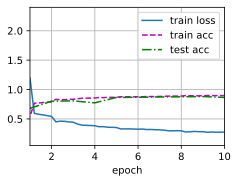

In [58]:
lr, num_epochs = 0.9,10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())